# Imports

In [72]:
import os
import zipfile
import gzip
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv
%matplotlib inline

# Old Data

# CSV Extraction

In [19]:
dir_name = 'Raw Zip'
extension = ".zip"

# Unzip
for item in os.listdir(dir_name): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = os.path.join(dir_name, item)
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(dir_name) # extract file to dir
        zip_ref.close() # close file

#Move to other folder
source_folder = "Raw Zip"
dest_folder = "Raw CSV Files"
for item in os.listdir(source_folder): 
    if(item.startswith("API") and item.endswith("csv")): 
        file_name = os.path.join(source_folder, item)
        shutil.move(file_name, os.path.join(dest_folder, item))
        
# Cleaning csv from zip folder
for item in os.listdir(dir_name):
    if item.endswith("csv"):
        file_name = os.path.join(dir_name, item)
        os.remove(file_name)

# Merge CSVs

In [20]:
csv_dir = "Raw CSV Files"
csv_list = []  
feature_list_of_lists = []
country_name_list_of_lists = []
for item in os.listdir(csv_dir):
    file_name = os.path.join(csv_dir, item)
    temp_df = pd.read_csv(file_name, skiprows = 4)
    country_name_list_of_lists.append(temp_df['Country Name'])
    feature_list_of_lists.append(temp_df.columns)
    csv_list.append(temp_df)

# Getting common features and countries to combine
common_countries = set.intersection(*[set(l) for l in country_name_list_of_lists])
common_features = set.intersection(*[set(l) for l in feature_list_of_lists])

all_df = pd.DataFrame([])
for i, individual_df in zip(range(len(csv_list)), csv_list):
    csv_list[i] = individual_df[sorted(common_features)]
    all_df = pd.concat([all_df, csv_list[i]])
all_df.reset_index(inplace = True, drop = True)
all_df.drop(columns = ['Indicator Code', 'Country Code'], inplace  = True)

In [21]:
all_df

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2013,2014,2015,2016,2017,2018,2019,2020,Country Name,Indicator Name
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,Aruba,Access to electricity (% of population)
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.046478,31.323579,33.312163,38.380433,39.754201,42.168241,43.640661,NaN,Africa Eastern and Southern,Access to electricity (% of population)
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68.982941,89.500000,71.500000,97.700000,97.700000,98.715622,97.700000,NaN,Afghanistan,Access to electricity (% of population)
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,47.018163,47.745499,46.752279,50.948939,48.848205,51.253253,51.341421,NaN,Africa Western and Central,Access to electricity (% of population)
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.248993,32.000000,42.000000,41.797379,43.001610,45.290000,45.670315,NaN,Angola,Access to electricity (% of population)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,70.943902,71.243902,71.495122,71.743902,71.995122,72.243902,72.495122,NaN,Kosovo,"Life expectancy at birth, total (years)"
5582,29.919,30.163,30.500,30.943,31.501,32.175,32.960,33.836,34.780,35.780,...,66.016000,66.066000,66.085000,66.087000,66.086000,66.096000,66.125000,66.181,"Yemen, Rep.","Life expectancy at birth, total (years)"
5583,48.406,48.777,49.142,49.509,49.888,50.284,50.705,51.148,51.615,52.106,...,61.099000,61.968000,62.649000,63.153000,63.538000,63.857000,64.131000,64.379,South Africa,"Life expectancy at birth, total (years)"
5584,46.687,47.084,47.446,47.772,48.068,48.351,48.643,48.960,49.313,49.700,...,59.746000,60.831000,61.737000,62.464000,63.043000,63.510000,63.886000,64.194,Zambia,"Life expectancy at birth, total (years)"


# ILOSTAT Data

# FTP

In [42]:
import requests
from bs4 import BeautifulSoup
import urllib.request
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

 
 
url = 'https://www.ilo.org/ilostat-files/WEB_bulk_download/html/bulk_indicator.html'
reqs = requests.get(url)
soup = BeautifulSoup(reqs.text, 'html.parser')
 
urls = []
initial_url = "https://www.ilo.org"
destination = "Raw GZ"
for link in soup.find_all('a'):
    print(initial_url + link.get('href'))
    urllib.request.urlretrieve((initial_url + link.get('href')), os.path.join(destination, link.get('href').split("/")[-1]))
    


https://www.ilo.org/ilostat-files/WEB_bulk_download/html/bulk_main.html
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/table_of_contents_en.csv
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/table_of_contents_fr.csv
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/table_of_contents_es.csv
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/CLD_TPOP_SEX_AGE_GEO_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/CLD_TPOP_SEX_AGE_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/CLD_TPOP_SEX_AGE_STU_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/CLD_XCHD_SEX_AGE_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/CLD_XCHL_SEX_AGE_ECO_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/CLD_XCHL_SEX_AGE_GEO_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/CLD_XCHL_SEX_AGE_GEO_RT_A.csv.gz 
htt

https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EAP_TEAP_SEX_AGE_MTS_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EAP_TEAP_SEX_AGE_MTS_NB_Q.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EAP_TEAP_SEX_AGE_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EAP_TEAP_SEX_AGE_NB_M.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EAP_TEAP_SEX_AGE_NB_Q.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EAP_TEAP_SEX_DSB_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EAP_TEAP_SEX_EDU_GEO_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EAP_TEAP_SEX_EDU_MTS_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EAP_TEAP_SEX_EDU_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EAP_TEAP_SEX_EDU_NB_Q.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EA

https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EIP_NEET_SEX_MTS_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EIP_NEET_SEX_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EIP_NEET_SEX_NB_Q.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EIP_NEET_SEX_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EIP_NEET_SEX_RT_Q.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EIP_TEIP_SEX_AGE_EDU_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EIP_TEIP_SEX_AGE_EDU_NB_M.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EIP_TEIP_SEX_AGE_EDU_NB_Q.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EIP_TEIP_SEX_AGE_GEO_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EIP_TEIP_SEX_AGE_GEO_NB_M.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EIP_TEIP_SEX_A

https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_DWAP_SEX_GEO_MTS_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_DWAP_SEX_GEO_MTS_RT_Q.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_DWAP_SEX_MTS_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_NIFL_SEX_AGE_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_NIFL_SEX_AGE_NB_Q.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_NIFL_SEX_AGE_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_NIFL_SEX_AGE_RT_Q.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_NIFL_SEX_ECO_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_NIFL_SEX_ECO_NB_Q.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_NIFL_SEX_ECO_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_NIFL_S

https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_TEMP_SEX_OCU_GEO_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_TEMP_SEX_OCU_INS_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_TEMP_SEX_OCU_MTS_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_TEMP_SEX_OCU_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_TEMP_SEX_OCU_NB_M.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_TEMP_SEX_OCU_NB_Q.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_TEMP_SEX_STE_ECO_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_TEMP_SEX_STE_ECO_NB_Q.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_TEMP_SEX_STE_GEO_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/EMP_TEMP_SEX_STE_MTS_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/

https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/HOW_XEES_SEX_OCU_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/HOW_XEES_SEX_OCU_NB_M.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/HOW_XEES_SEX_OCU_NB_Q.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/ILR_CBCT_NOC_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/ILR_TUMT_NOC_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/INJ_DAYS_ECO_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/INJ_DAYS_SEX_MIG_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/INJ_FATL_ECO_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/INJ_FATL_ECO_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/INJ_FATL_SEX_MIG_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/INJ_FATL_SEX_MIG_RT_A.csv.gz 
https://

https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/MST_TEIP_SEX_EDU_CCT_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/MST_TEMP_SEX_AGE_CBR_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/MST_TEMP_SEX_AGE_CBR_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/MST_TEMP_SEX_AGE_CCT_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/MST_TEMP_SEX_AGE_CCT_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/MST_TEMP_SEX_ECO_CBR_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/MST_TEMP_SEX_ECO_CCT_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/MST_TEMP_SEX_EDU_CBR_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/MST_TEMP_SEX_EDU_CBR_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/MST_TEMP_SEX_EDU_CCT_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bu

https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/TRU_DEMP_SEX_AGE_MTS_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/TRU_DEMP_SEX_AGE_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/TRU_DEMP_SEX_AGE_RT_M.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/TRU_DEMP_SEX_AGE_RT_Q.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/TRU_DEMP_SEX_EDU_GEO_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/TRU_DEMP_SEX_EDU_MTS_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/TRU_DEMP_SEX_EDU_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/TRU_DEMP_SEX_GEO_MTS_RT_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/TRU_DEMP_SEX_GEO_MTS_RT_Q.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indicator/TRU_TTRU_SEX_AGE_GEO_NB_A.csv.gz 
https://www.ilo.org/ilostat-files/WEB_bulk_download/indi

# Loading CSVs

In [44]:
# Extract Annual CSVs from GZ archives
Raw_GZ = "Raw GZ"
Raw_ILOSTAT = "Raw ILOSTAT"
for item in os.listdir(Raw_GZ):
  if(item.endswith('A.csv.gz')):
    out_name = item.split('.')[0 : -1]
    out_name = ".".join(out_name)
    print(out_name)
    with gzip.open(os.path.join(Raw_GZ, item), 'rb') as f_in:
        with open(os.path.join(Raw_ILOSTAT, out_name), 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)


CLD_TPOP_SEX_AGE_GEO_NB_A.csv
CLD_TPOP_SEX_AGE_NB_A.csv
CLD_TPOP_SEX_AGE_STU_NB_A.csv
CLD_XCHD_SEX_AGE_NB_A.csv
CLD_XCHL_SEX_AGE_ECO_NB_A.csv
CLD_XCHL_SEX_AGE_GEO_NB_A.csv
CLD_XCHL_SEX_AGE_GEO_RT_A.csv
CLD_XCHL_SEX_AGE_NB_A.csv
CLD_XCHL_SEX_AGE_RT_A.csv
CLD_XCHL_SEX_AGE_STE_NB_A.csv
CLD_XCHL_SEX_AGE_STU_NB_A.csv
CLD_XCHL_SEX_AGE_STU_RT_A.csv
CLD_XCHN_SEX_AGE_GEO_NB_A.csv
CLD_XCHS_SEX_AGE_GEO_NB_A.csv
CLD_XHAD_SEX_AGE_NB_A.csv
CLD_XHAN_SEX_AGE_GEO_NB_A.csv
CLD_XHAS_SEX_AGE_GEO_NB_A.csv
CLD_XHAZ_SEX_AGE_ECO_NB_A.csv
CLD_XHAZ_SEX_AGE_GEO_NB_A.csv
CLD_XHAZ_SEX_AGE_GEO_RT_A.csv
CLD_XHAZ_SEX_AGE_NB_A.csv
CLD_XHAZ_SEX_AGE_RT_A.csv
CLD_XHAZ_SEX_AGE_STE_NB_A.csv
CLD_XHAZ_SEX_AGE_STU_NB_A.csv
CLD_XHAZ_SEX_AGE_STU_RT_A.csv
CLD_XSNA_SEX_AGE_ECO_NB_A.csv
CLD_XSNA_SEX_AGE_GEO_NB_A.csv
CLD_XSNA_SEX_AGE_GEO_RT_A.csv
CLD_XSNA_SEX_AGE_NB_A.csv
CLD_XSNA_SEX_AGE_RT_A.csv
CLD_XSNA_SEX_AGE_STE_NB_A.csv
CLD_XSNA_SEX_AGE_STU_NB_A.csv
CLD_XSNA_SEX_AGE_STU_RT_A.csv
CLD_XSND_SEX_AGE_NB_A.csv
CLD_XSNN_SEX_AGE_GEO

LUU_2LU4_SEX_AGE_RT_A.csv
LUU_XLU2_SEX_AGE_GEO_RT_A.csv
LUU_XLU2_SEX_AGE_MTS_RT_A.csv
LUU_XLU2_SEX_AGE_RT_A.csv
LUU_XLU2_SEX_EDU_GEO_RT_A.csv
LUU_XLU2_SEX_EDU_MTS_RT_A.csv
LUU_XLU3_SEX_AGE_GEO_RT_A.csv
LUU_XLU3_SEX_AGE_MTS_RT_A.csv
LUU_XLU3_SEX_AGE_RT_A.csv
LUU_XLU3_SEX_EDU_GEO_RT_A.csv
LUU_XLU3_SEX_EDU_MTS_RT_A.csv
LUU_XLU4_SEX_AGE_GEO_RT_A.csv
LUU_XLU4_SEX_AGE_MTS_RT_A.csv
LUU_XLU4_SEX_AGE_RT_A.csv
LUU_XLU4_SEX_EDU_GEO_RT_A.csv
LUU_XLU4_SEX_EDU_MTS_RT_A.csv
MFL_FEMP_SEX_ECO_NB_A.csv
MFL_FEMP_SEX_OCU_NB_A.csv
MFL_FPOP_SEX_CBR_NB_A.csv
MFL_FWAP_SEX_EDU_NB_A.csv
MFL_NCIT_SEX_CCT_NB_A.csv
MFL_NEMP_SEX_ECO_NB_A.csv
MFL_NEMP_SEX_OCU_NB_A.csv
MFL_NWAP_SEX_EDU_NB_A.csv
MNA_OEMP_SEX_CDS_NB_A.csv
MNA_OEMP_SEX_ECO_NB_A.csv
MNA_OEMP_SEX_EDU_NB_A.csv
MNA_OEMP_SEX_OCU_NB_A.csv
MNA_OPOP_SEX_CDS_NB_A.csv
MNA_TPOP_SEX_CRS_NB_A.csv
MNA_XRET_SEX_CPR_NB_A.csv
MST_EARA_SEX_CBR_NB_A.csv
MST_EARA_SEX_CCT_NB_A.csv
MST_FORE_SEX_CBR_NB_A.csv
MST_FORP_SEX_CBR_NB_A.csv
MST_NCTE_SEX_CCT_NB_A.csv
MST_NCTP_SEX_CCT

In [86]:
# Combine df if NaNs <= 30% and pivot with mean and merge
all_df = pd.DataFrame([])
i = 0
for item in os.listdir(Raw_ILOSTAT):
    if(item.endswith('A.csv')):
        temp_df = pd.read_csv(os.path.join(Raw_ILOSTAT,item))
#         temp_df = pd.pivot_table(temp_df, values = 'obs_value', index = ['ref_area','indicator'], columns = 'time').reset_index()
        # Drop df if %NaN values more than 30%
#         print(temp_df.isna().sum().sum())
#         print((temp_df.shape[0] * temp_df.shape[1]) * 0.3)
#         print(temp_df.shape[0] * temp_df.shape[1])
#         if( (temp_df['obs_value'].isna().sum() / len(temp_df)) >= 0.3 ):
#             continue
#         if(temp_df.isna().sum().sum() >= ((temp_df.shape[0] * temp_df.shape[1]) * 0.3) ):
#             continue
        temp_df = pd.pivot_table(temp_df, values = 'obs_value', index = ['ref_area', 'indicator'], columns = 'time').reset_index()
        all_df = pd.concat([all_df, temp_df])
        print(i)
        i += 1
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [87]:
all_df

,ref_area,indicator,2010,2012,2013,2014,2015,2016,2017,2018,...,1943,1944,1945,2024,2025,2026,2027,2028,2029,2030
0,AFG,CLD_TPOP_SEX_AGE_GEO_NB,NaN,NaN,NaN,2296.650889,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARG,CLD_TPOP_SEX_AGE_GEO_NB,NaN,NaN,NaN,NaN,NaN,NaN,2111.885111,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ARM,CLD_TPOP_SEX_AGE_GEO_NB,NaN,NaN,NaN,NaN,102.208583,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BLZ,CLD_TPOP_SEX_AGE_GEO_NB,NaN,NaN,24.442222,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BOL,CLD_TPOP_SEX_AGE_GEO_NB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,VEN,UNE_TUNE_SEX_OCU_NB,250.9664,280.977000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,VNM,UNE_TUNE_SEX_OCU_NB,NaN,70.927733,97.425267,85.754467,149.316600,143.666733,153.461200,96.3456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,YEM,UNE_TUNE_SEX_OCU_NB,NaN,NaN,NaN,55.088289,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,ZAF,UNE_TUNE_SEX_OCU_NB,426.2694,439.161480,460.028600,489.961255,524.176640,558.958020,591.915160,588.3473,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
col = ['ref_area',
 'indicator',
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020]

<AxesSubplot:>

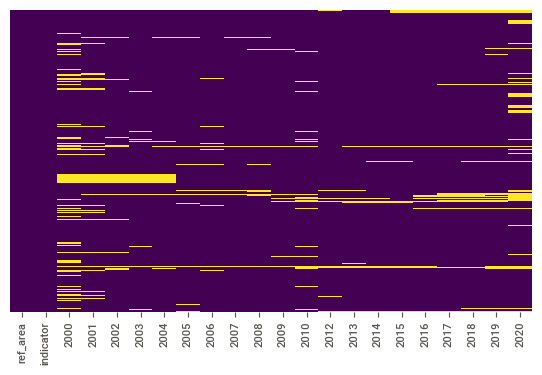

In [165]:
less_null_index = np.where( all_df.isnull().sum(axis=1) < 75 )
less_null_df = all_df.iloc[less_null_index][col]
sns.heatmap(less_null_df.isnull(), cbar = False, 
            cmap = 'viridis', yticklabels = False)


In [175]:
less_null_df['indicator'].value_counts().head(25)

EMP_2EMP_AGE_STE_NB        283
POP_2POP_GEO_NB            283
EMP_2EMP_SEX_ECO_NB        283
EMP_2EMP_SEX_OCU_NB        283
EMP_2EMP_SEX_AGE_NB        278
EAP_2WAP_SEX_AGE_RT        278
EMP_2EMP_SEX_STE_NB        278
UNE_2UNE_SEX_AGE_NB        278
EIP_2EIP_SEX_AGE_NB        278
POP_2LDR_NOC_RT            278
HOW_2TOT_NOC_NB            278
EIP_2WAP_SEX_AGE_RT        278
GDP_211P_NOC_NB            278
EAP_2EAP_SEX_AGE_NB        278
POP_2POP_SEX_AGE_NB        278
UNE_2EAP_SEX_AGE_RT        278
HOW_2TDP_NOC_RT            278
EMP_2WAP_SEX_AGE_RT        278
GDP_205U_NOC_NB            278
EAP_2MDN_SEX_NB            219
SDG_B821_NOC_RT            199
SDG_A821_NOC_RT            199
CPI_ACPI_COI_RT            195
EMP_2EMP_SEX_AGE_CLA_NB    195
SDG_0111_SEX_AGE_RT        127
Name: indicator, dtype: int64

In [185]:
required_indicators = less_null_df['indicator'].value_counts().head(25).index
temp_list = []
for ind in required_indicators:
    temp_list.append(less_null_df[less_null_df['indicator'] == ind]['ref_area'].unique())
    
    
final_countries = set.intersection(*[set(l) for l in temp_list])
final_df = less_null_df[less_null_df['ref_area'].isin(final_countries) & less_null_df['indicator'].isin(required_indicators)]

In [187]:
final_df.to_csv('final.csv', index = False)
pd.read_csv('final.csv')

,ref_area,indicator,2000,2001,2002,2003,2004,2005,2006,2007,...,2010,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,AGO,CPI_ACPI_COI_RT,306.970000,151.855000,105.700000,103.555000,46.485000,23.120000,15.225000,13.215000,...,14.470000,11.390000,8.780000,7.400000,NaN,NaN,NaN,NaN,NaN,NaN
1,ALB,CPI_ACPI_COI_RT,2.055000,5.001667,5.721667,1.558333,5.788333,5.036667,3.010000,2.170000,...,3.260000,2.195000,3.080000,1.915000,NaN,NaN,NaN,NaN,NaN,NaN
2,ARG,CPI_ACPI_COI_RT,-1.541667,-1.733333,21.310000,12.643333,3.671667,9.205000,10.705000,11.202500,...,10.937500,10.150000,9.085000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARM,CPI_ACPI_COI_RT,-1.630000,1.641667,1.220000,3.361667,6.570000,2.648333,4.323333,4.031667,...,8.785000,2.270000,5.800000,2.350000,NaN,NaN,NaN,NaN,NaN,NaN
4,AZE,CPI_ACPI_COI_RT,2.405000,1.340000,2.580000,1.937500,7.162500,24.165000,9.702500,42.407500,...,6.265000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,VNM,UNE_2UNE_SEX_AGE_NB,397.091667,502.394111,391.943111,421.725333,406.187556,411.969778,423.957889,426.373778,...,252.456333,240.758778,315.564889,304.585000,452.794556,453.665778,460.308000,286.142333,506.819000,593.628111
2571,YEM,UNE_2UNE_SEX_AGE_NB,206.614222,214.758111,222.354889,230.225556,238.483333,246.949778,256.392889,265.810778,...,293.483222,312.692333,320.304444,330.253556,351.756111,355.515111,364.285556,372.256667,381.879778,399.349333
2572,ZAF,UNE_2UNE_SEX_AGE_NB,2248.746667,2354.512333,2602.387222,2572.517000,2386.808444,2400.839667,2374.381778,2258.411000,...,2065.185667,2148.845778,2195.121889,2272.471556,2389.711000,2567.622000,2687.241778,2703.947556,2908.937333,2772.109333
2573,ZMB,UNE_2UNE_SEX_AGE_NB,255.022222,272.836444,291.935444,311.156000,331.797444,353.501778,299.010222,242.965444,...,319.959000,199.643222,226.685222,255.308889,286.202222,318.442778,353.196778,378.300222,408.906667,431.237778


<AxesSubplot:>

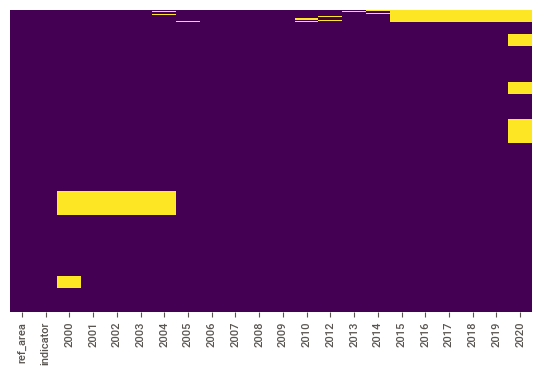

In [188]:
sns.heatmap(pd.read_csv('final.csv').isnull(), cbar = False, 
            cmap = 'viridis', yticklabels = False)

# EDA on Table of Contents

In [61]:
table_of_contents_df = pd.read_csv("Raw GZ/table_of_contents_en.csv")
table_of_contents_df

,id,indicator,indicator.label,freq,freq.label,size,data.start,data.end,last.update,n.records,collection,collection.label,subject,subject.label,database,database.label
0,HOW_2LSS_NOC_RT_A,HOW_2LSS_NOC_RT,Working hours lost due to the COVID-19 crisis -- ILO modelled estimates (%),A,Annual,7.37 KB,2020,2023,07/01/2022 12:29:51,1112,COVID,COVID Monitor,HOW,Working time,COVID,COVID Monitor
1,HOW_2LSS_NOC_RT_Q,HOW_2LSS_NOC_RT,Working hours lost due to the COVID-19 crisis -- ILO modelled estimates (%),Q,Quarterly,4.43 KB,2020Q1,2021Q4,07/01/2022 12:29:32,712,COVID,COVID Monitor,HOW,Working time,COVID,COVID Monitor
2,HOW_2FTE_JOB_NB_A,HOW_2FTE_JOB_NB,Working hours lost due to the COVID-19 crisis expressed as number of FTE jobs -- ILO modelled estimates (thousands),A,Annual,17.64 KB,2020,2023,07/01/2022 12:29:51,2224,COVID,COVID Monitor,HOW,Working time,COVID,COVID Monitor
3,HOW_2FTE_JOB_NB_Q,HOW_2FTE_JOB_NB,Working hours lost due to the COVID-19 crisis expressed as number of FTE jobs -- ILO modelled estimates (thousands),Q,Quarterly,11.97 KB,2020Q1,2021Q4,07/01/2022 12:29:32,1424,COVID,COVID Monitor,HOW,Working time,COVID,COVID Monitor
4,HOW_2TOT_NOC_NB_A,HOW_2TOT_NOC_NB,Total weekly hours worked of employed persons -- ILO modelled estimates (thousands),A,Annual,47.14 KB,2005,2023,07/01/2022 12:29:51,5282,COVID,COVID Monitor,HOW,Working time,COVID,COVID Monitor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,EMP_PIFL_SEX_ECO_RT_Q,EMP_PIFL_SEX_ECO_RT,Share of employment outside the formal sector by sex and economic activity (%),Q,Quarterly,293.83 KB,1995Q2,2021Q4,07/04/2022 18:23:03,55321,STI,Short-term labour force indicators (STLFS),EMP;WOM;IFL,Employment | Women | Informal sector and informal employment,STLFS,Short-term labour force statistics (STLFS)
694,EMP_PIFL_SEX_STE_RT_A,EMP_PIFL_SEX_STE_RT,Share of employment outside the formal sector by status in employment (by sex) (%),A,Annual,88.56 KB,1997,2021,07/04/2022 18:23:56,15801,YI,Annual indicators,EMP;IFL;WOM,Employment | Informal sector and informal employment | Women,LFS,Labour force statistics (LFS)
695,EMP_PIFL_SEX_STE_RT_Q,EMP_PIFL_SEX_STE_RT,Share of employment outside the formal sector by status in employment (by sex) (%),Q,Quarterly,71.82 KB,1995Q2,2021Q4,07/04/2022 18:23:12,12728,STI,Short-term labour force indicators (STLFS),EMP;IFL;WOM,Employment | Informal sector and informal employment | Women,STLFS,Short-term labour force statistics (STLFS)
696,EMP_STAT_SEX_STE_EDU_NB_A,EMP_STAT_SEX_STE_EDU_NB,"Employment by sex, status in employment and 'educational mismatch', statistical approach (thousands)",A,Annual,355.86 KB,2001,2021,09/04/2022 11:17:31,40466,YI,Annual indicators,EMP,Employment,SKILLS,Education and skills mismatch indicators (SKILLS)


In [90]:
#analyzing the dataset
df_analysis=sv.analyze(table_of_contents_df)


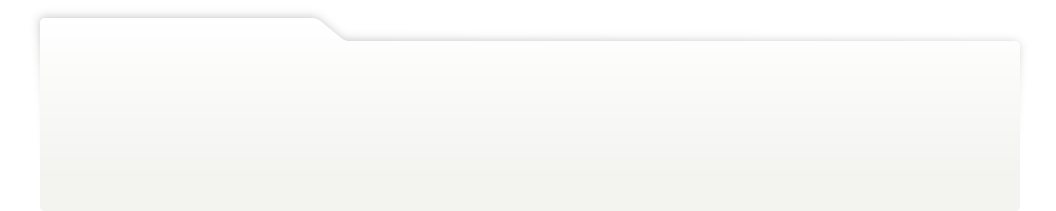
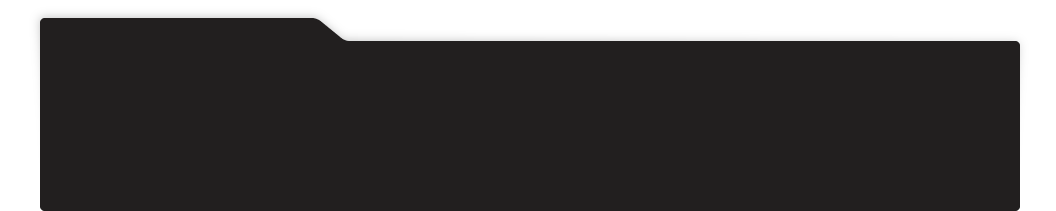
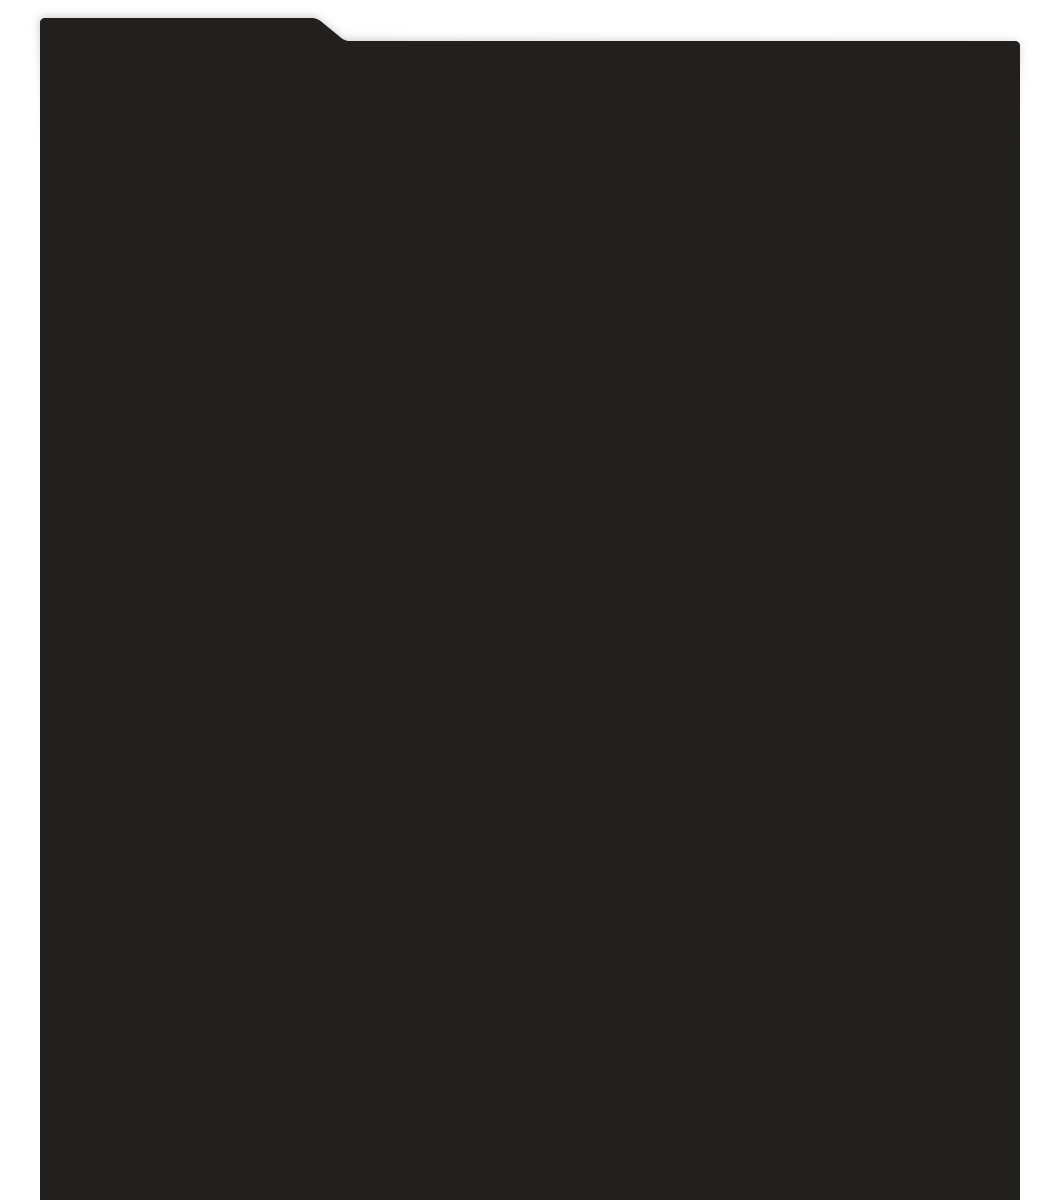
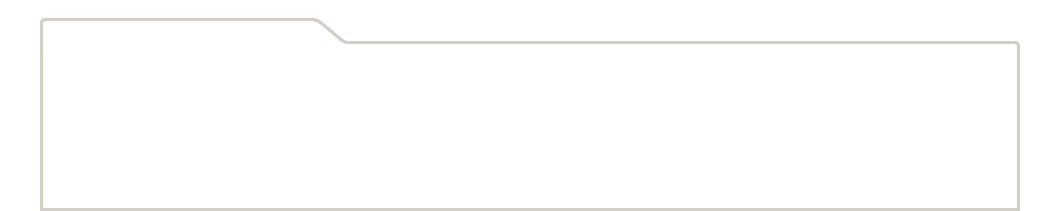
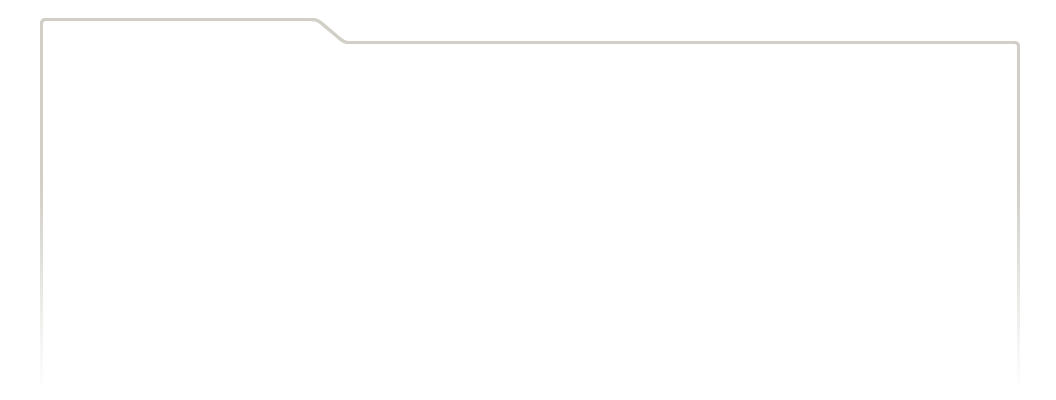
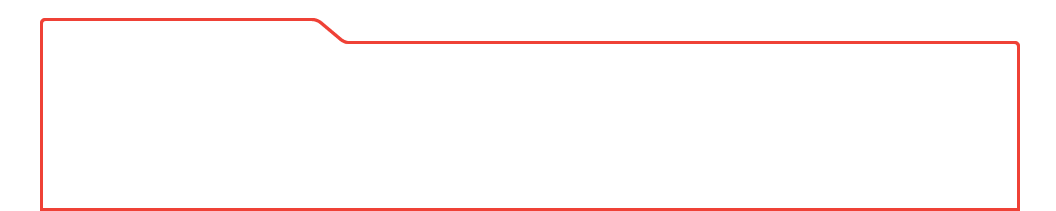
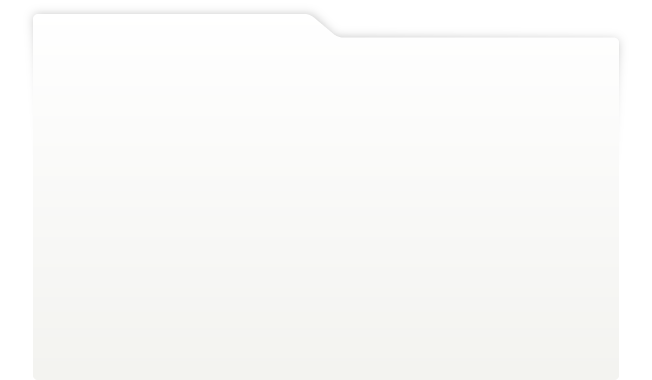
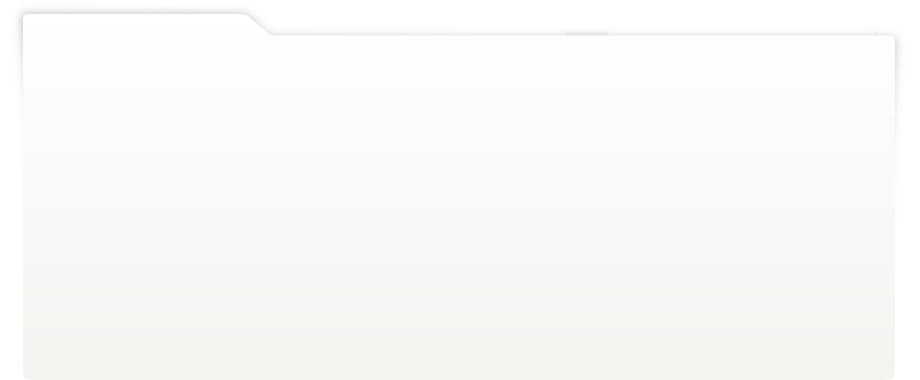
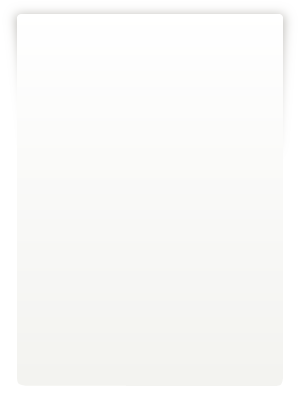
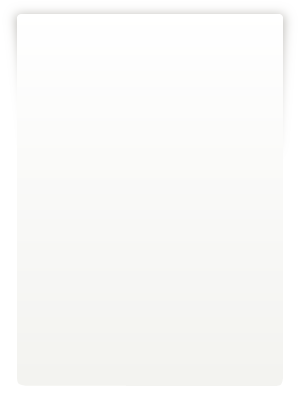
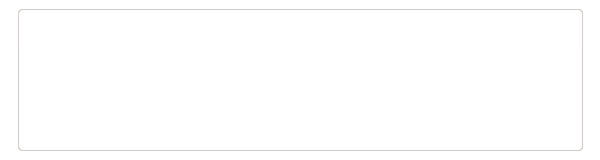
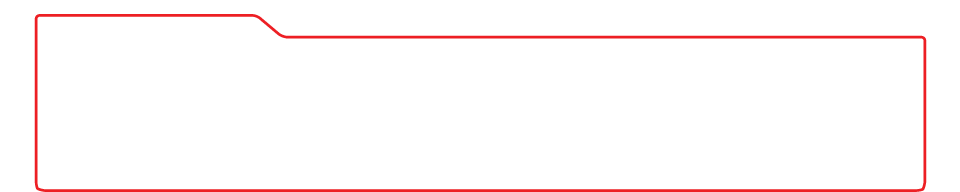
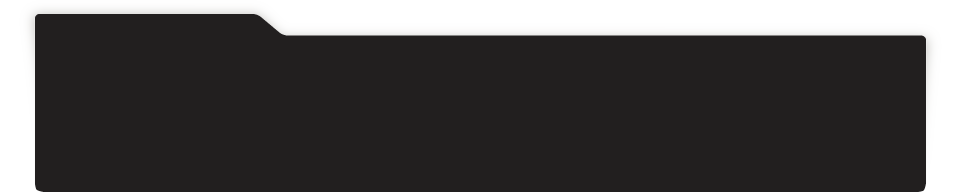
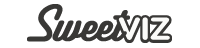
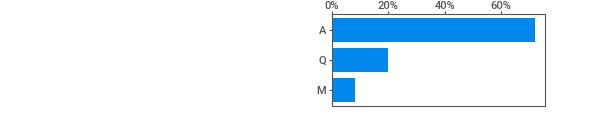
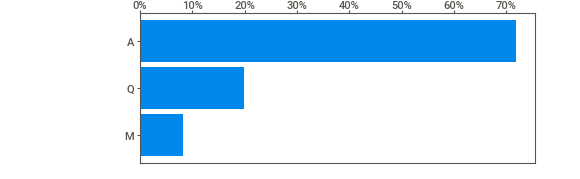
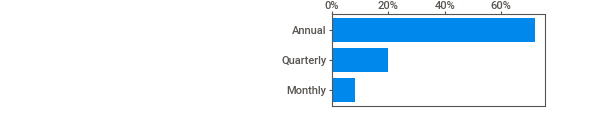
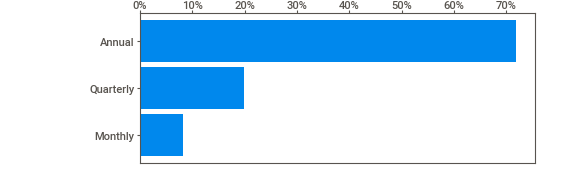
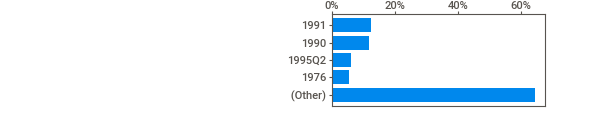
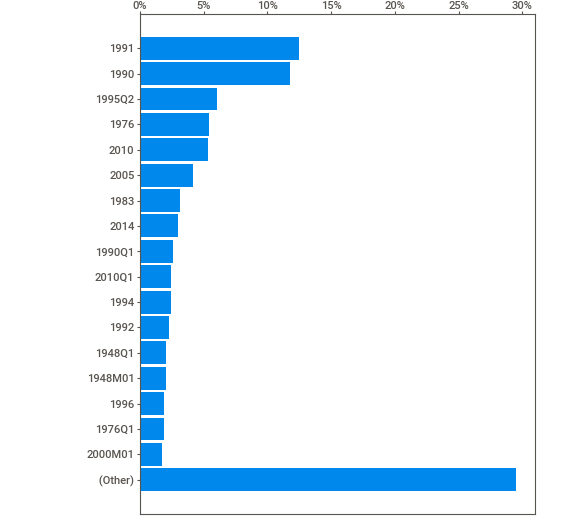
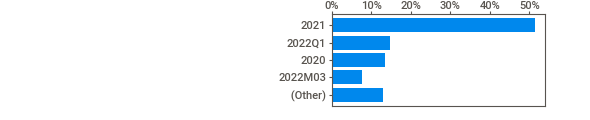
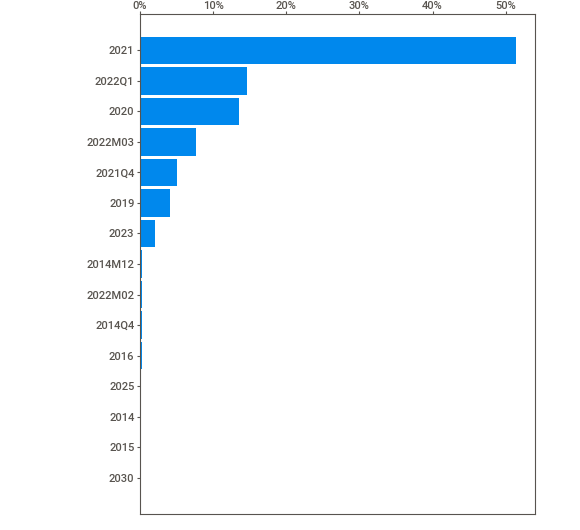
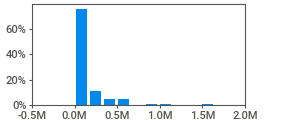
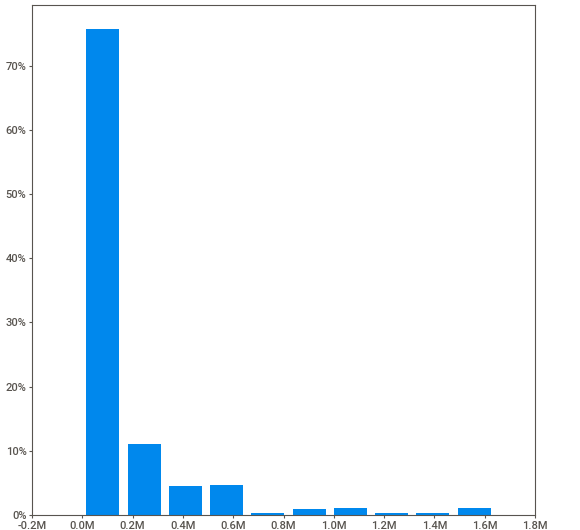
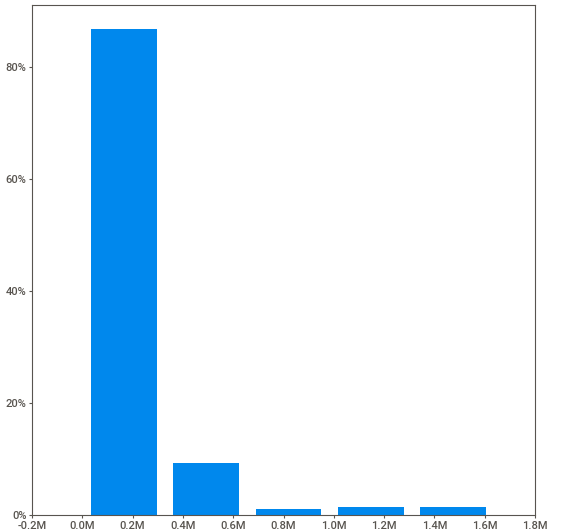
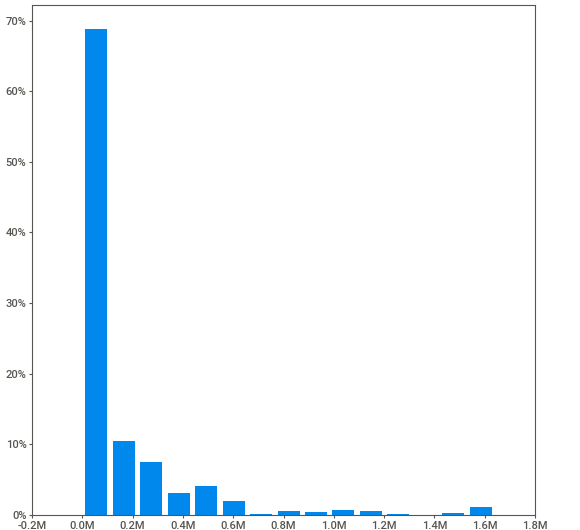
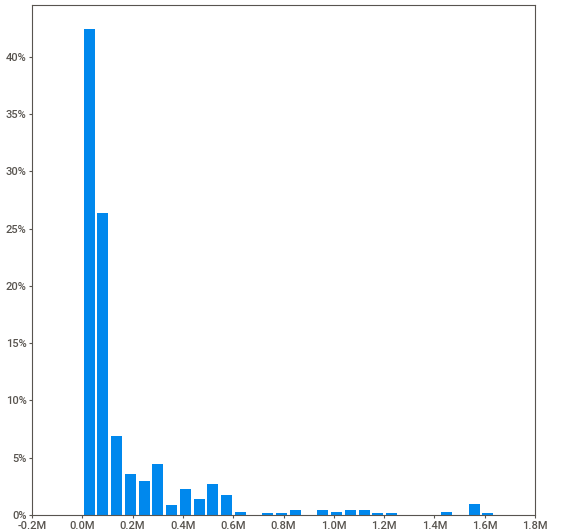
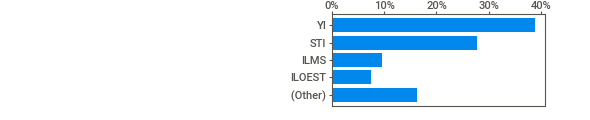
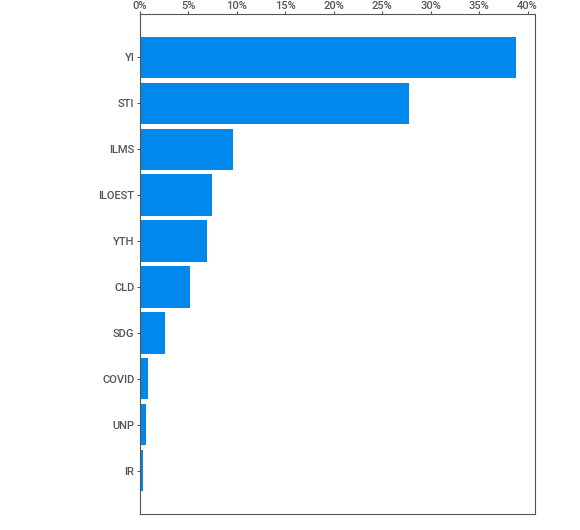
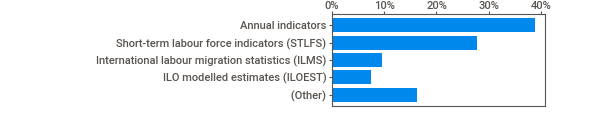
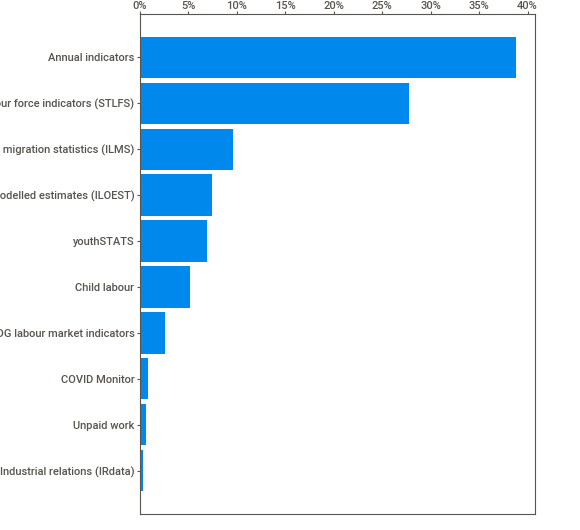
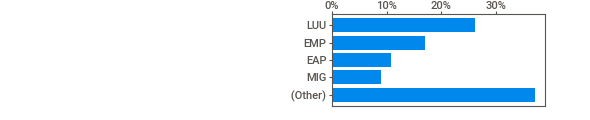
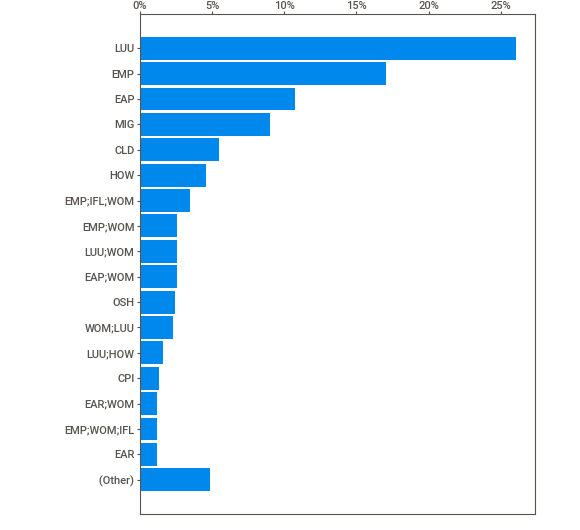
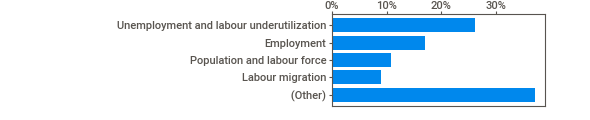
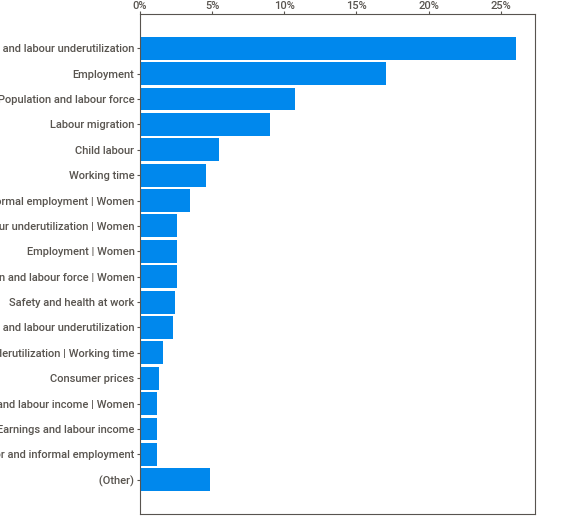
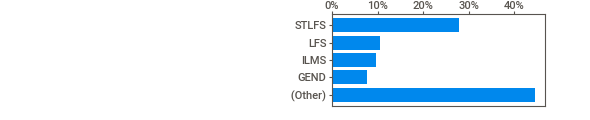
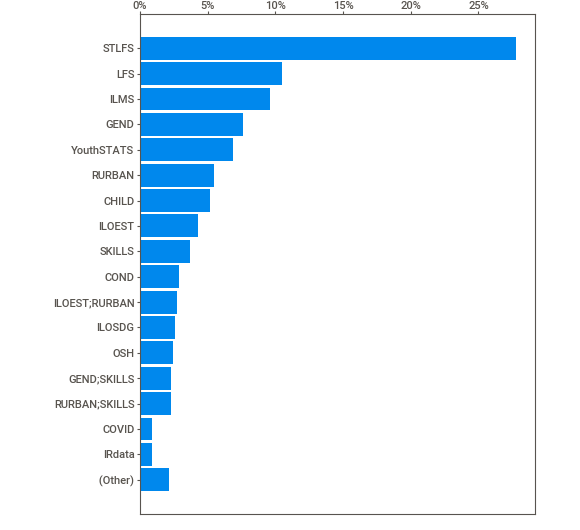
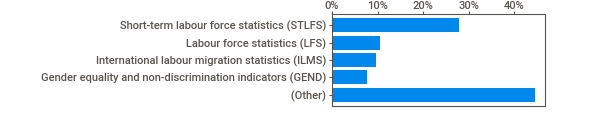
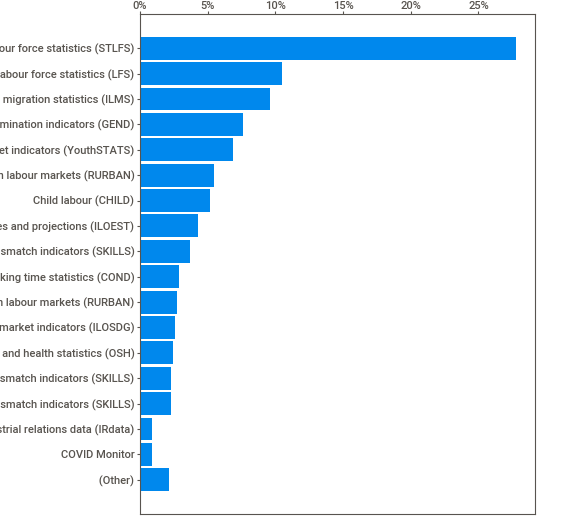
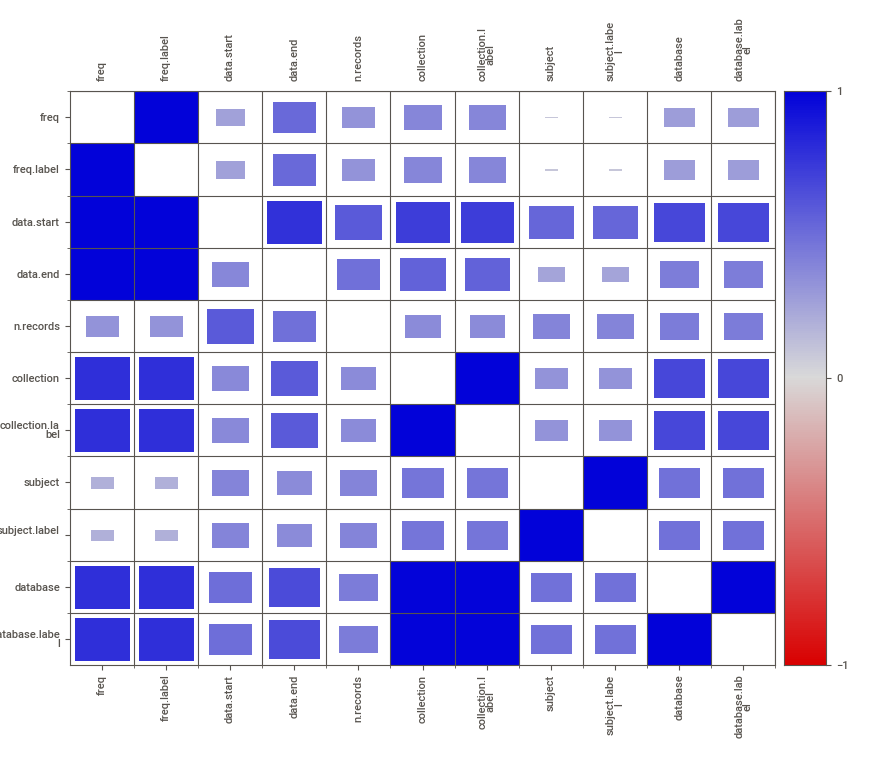
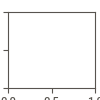

In [91]:
df_analysis.show_notebook()

In [128]:
# Based on size
required_indicators = table_of_contents_df.sort_values('size')
required_indicators[required_indicators['id'].str.endswith('A')][['id', 'size']].sort_values('size').head(30)

,id,size
380,EIP_WPLF_SEX_EDU_MTS_NB_A,1.02 MB
188,EMP_TEMP_SEX_OCU_NB_A,1.04 MB
488,HOW_TEMP_SEX_ECO_NB_A,1.04 MB
588,MST_TEMP_SEX_OCU_CCT_NB_A,1.04 MB
34,EMP_2EMP_SEX_AGE_GEO_NB_A,1.05 MB
29,EAP_2EAP_SEX_AGE_GEO_NB_A,1.05 MB
505,HOW_XEES_SEX_ECO_NB_A,1.08 MB
369,EIP_WDIS_SEX_AGE_MTS_NB_A,1.09 MB
243,EES_TEES_AGE_EC2_NB_A,1.09 MB
558,MST_XWAP_SEX_EDU_CBR_NB_A,1.09 MB
